# 5章 バンディットアルゴリズム：テスト中の損失にも向き合う

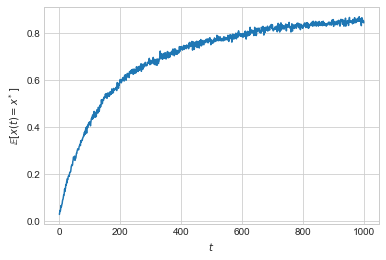

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
np.random.seed(0)

# ε-greedyアルゴリズムの正解率の推移
n_arms = 4

class Env:
    thetas = [0.1, 0.1, 0.2, 0.3]

    def react(arm):
        return 1 if np.random.random() < Env.thetas[arm] else 0
    
    def opt():
        return np.argmax(Env.thetas)

class EpsilonGreedyAgent:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
    
    def get_arm(self):
        if np.random.random() < self.epsilon:
            arm = np.random.randint(n_arms)
        else:
            arm = np.argmax(self.values)
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = ((self.counts[arm] - 1) * self.values[arm] + reward) / self.counts[arm]

def sim(Agent, N=1000, T=1000, **kwargs):
    selected_arms = [[0 for _ in range(T)] for _ in range(N)]
    earned_rewards = [[0 for _ in range(T)] for _ in range(N)]

    for n in range(N):
        agent = Agent(**kwargs)
        for t in range(T):
            arm = agent.get_arm()
            reward = Env.react(arm)
            agent.sample(arm, reward)
            selected_arms[n][t] = arm
            earned_rewards[n][t] = reward
    return np.array(selected_arms), np.array(earned_rewards)

arms_eg, rewards_eg = sim(EpsilonGreedyAgent)
acc = np.mean(arms_eg == Env.opt(), axis=0)

plt.plot(acc)
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.show()

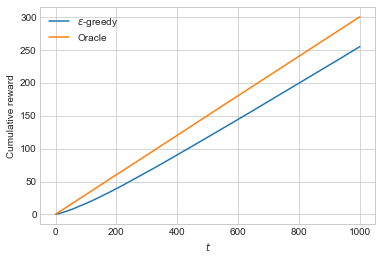

In [4]:
# ε-greedyと全知全能エージェントの累積報酬の比較
class OracleAgent:
    def __init__(self):
        self.arm = Env.opt()

    def get_arm(self):
        return self.arm
    
    def sample(self, arm, reward):
        pass

arms_o, rewards_o = sim(OracleAgent)
plt.plot(np.mean(np.cumsum(rewards_eg, axis=1), axis=0), label=r'$\varepsilon$-greedy')
plt.plot(np.mean(np.cumsum(rewards_o, axis=1), axis=0), label='Oracle')
plt.xlabel(r'$t$')
plt.ylabel('Cumulative reward')
plt.legend()
plt.show()

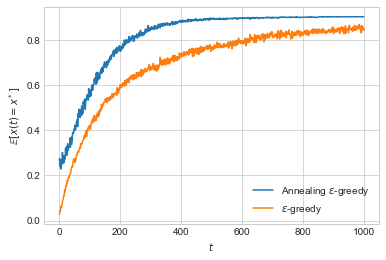

In [5]:
# 焼きなましε-greedyアルゴリズム
class AnnealingEpsilonGreedyAgent:
    def __init__(self, epsilon=1.0):
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
    
    def get_arm(self):
        if np.random.random() < self.epsilon:
            arm = np.random.randint(n_arms)
        else:
            arm = np.argmax(self.values)
        self.epsilon *= 0.99
        return arm
        
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = ((self.counts[arm] - 1) * self.values[arm] + reward) / self.counts[arm]


# 焼きなましε-greedyアルゴリズムの正解率の推移
arms_aeg, rewards_aeg = sim(AnnealingEpsilonGreedyAgent)

plt.plot(np.mean(arms_aeg == Env.opt(), axis=0), label=r'Annealing $\varepsilon$-greedy')
plt.plot(np.mean(arms_eg == Env.opt(), axis=0), label=r'$\varepsilon$-greedy')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

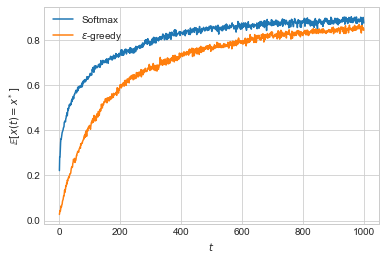

In [6]:
# ソフトマックスアルゴリズム
class SoftmaxAgent:
    def __init__(self, tau=0.05):
        self.tau = tau
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
    
    def softmax_p(self):
        logit = self.values / self.tau
        logit = logit - np.max(logit)
        p = np.exp(logit) / sum(np.exp(logit))
        return p
    
    def get_arm(self):
        arm = np.random.choice(n_arms, p=self.softmax_p())
        return arm
        
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = ((self.counts[arm] - 1) * self.values[arm] + reward) / self.counts[arm]

# ソフトマックスアルゴリズムの正解率の推移
arms_sm, rewards_sm = sim(SoftmaxAgent)

plt.plot(np.mean(arms_sm == Env.opt(), axis=0), label=r'Softmax')
plt.plot(np.mean(arms_eg == Env.opt(), axis=0), label=r'$\varepsilon$-greedy')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

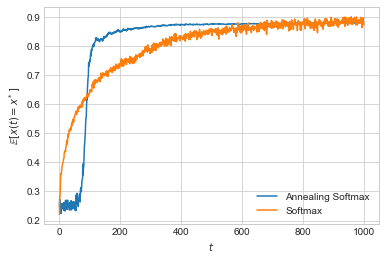

In [7]:
# 焼きなましソフトマックスアルゴリズムの正解率の推移
class AnnealingSoftmaxAgent:
    def __init__(self, tau=1000.0):
        self.tau = tau
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
    
    def softmax_p(self):
        logit = self.values / self.tau
        logit = logit - np.max(logit)
        p = np.exp(logit) / sum(np.exp(logit))
        return p
    
    def get_arm(self):
        arm = np.random.choice(n_arms, p=self.softmax_p())
        self.tau *= 0.9
        return arm
        
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = ((self.counts[arm] - 1) * self.values[arm] + reward) / self.counts[arm]

arms_asm, rewards_asm = sim(AnnealingSoftmaxAgent)

plt.plot(np.mean(arms_asm == Env.opt(), axis=0), label='Annealing Softmax')
plt.plot(np.mean(arms_sm == Env.opt(), axis=0), label='Softmax')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

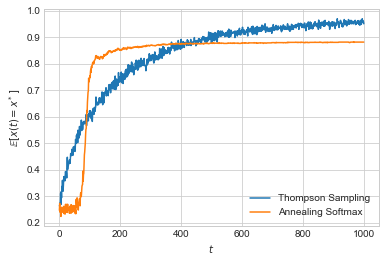

In [8]:
# トンプソン抽出の正解率の推移
class BernoulliTSAgent:
    def __init__(self):
        self.counts = [0 for _ in range(n_arms)]
        self.wins = [0 for _ in range(n_arms)]
    
    def get_arm(self):
        beta = lambda N, a: np.random.beta(a + 1, N - a + 1)
        result = [beta(self.counts[i], self.wins[i]) for i in range(n_arms)]
        arm = result.index(max(result))
        return arm
        
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.wins[arm] += reward

arms_ts, rewards_ts = sim(BernoulliTSAgent)

plt.plot(np.mean(arms_ts == Env.opt(), axis=0), label='Thompson Sampling')
plt.plot(np.mean(arms_asm == Env.opt(), axis=0), label='Annealing Softmax')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

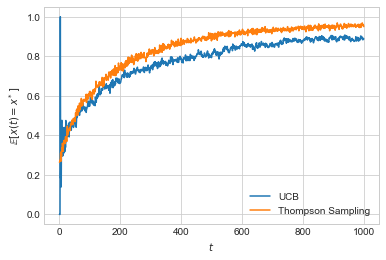

In [9]:
# UCBアルゴリズム
class UCBAgent:
    def __init__(self):
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0 for _ in range(n_arms)]
    
    def calc_ucb(self, arm):
        ucb = self.values[arm]
        ucb += np.sqrt(np.log(sum(self.counts)) / (2 * self.counts[arm]))
        return ucb
    
    def get_arm(self):
        if 0 in self.counts:
            arm = self.counts.index(0)
        else:
            ucb = [self.calc_ucb(arm) for arm in range(n_arms)]
            arm = ucb.index(max(ucb))
        return arm

    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = ((self.counts[arm] - 1) * self.values[arm] + reward) / self.counts[arm]
    
# UCBアルゴリズムの正解率の推移
arms_ucb, rewards_ucb = sim(UCBAgent)

plt.plot(np.mean(arms_ucb == Env.opt(), axis=0), label='UCB')
plt.plot(np.mean(arms_ts == Env.opt(), axis=0), label='Thompson Sampling')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()